In [1]:
import json
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import random
import shutil
import glob
import time

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor, DefaultTrainer,default_argument_parser, default_setup
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.events import EventStorage

from deepent.data.register_datasets import register_datasets
from deepent.config import add_deepent_config
from tools.vis import visualize_single, get_predictions
from tools.train_net import *
from tools.predictor import RGBDPredictor

In [2]:
def register_temporary_datasets(n_from_each_set=None,tile_paths = None):
        assert n_from_each_set is not None or tile_paths is not None, "You must pass either a number of tiles to sample from each dataset or an array of tile paths!"
        test_tiles = []
        test_tile_segs = []
        if tile_paths is not None:
            for tile_path in tile_paths:
                location = os.path.dirname(tile_path)
                with open(os.path.join(location,'segs.json'),'r') as segfile:
                        segs = json.load(segfile)
                        test_tile_segs.append(list(filter(lambda x : x["file_name"]==tile_path,segs)))
                test_tiles.append(tile_path)
        else:            
            for location in glob.glob('/home/ubuntu/RGBD-Training-Data/test/*'):
                filenames = glob.glob(location + '/*.png')
                with open(os.path.join(location,'segs.json'),'r') as segfile:
                    segs = json.load(segfile)
                    for ind in np.random.randint(0,len(filenames),n_from_each_set):
                        test_tiles.append(filenames[ind])
                        test_tile_segs.append(list(filter(lambda x : x["file_name"]==filenames[ind],segs)))

        test_dir = '/home/ubuntu/RGBD-Training-Data/test/'                
        folder_names = []             
        test_set_names = []
        set_tile_paths = {}
        for i,path in enumerate(test_tiles):
            folder_names.append('temporary_'+str(i))
            test_set_names.append(folder_names[-1] + "_test")
            set_tile_paths[test_set_names[-1]] = path
            os.mkdir(test_dir + folder_names[-1])
            shutil.copy(path, test_dir + folder_names[-1] + '/' + path.split('/')[-1])
            with open(os.path.join(test_dir,folder_names[-1],'segs.json'),'w') as segfile:
                segfile.write(json.dumps(test_tile_segs[i]))
        register_datasets(f'/home/ubuntu/RGBD-Training-Data/')
        return test_set_names, set_tile_paths

def find_losses(config, model,num_sets):
    data_loader = DefaultTrainer.build_train_loader(config)
    _data_loader_iter = iter(data_loader)
    losses = {}
    loss_dicts = {}
    while len(losses.items()) < num_sets:
        assert model.training, "[SimpleTrainer] model was changed to eval mode!"
        start = time.perf_counter()
        data = next(_data_loader_iter)
        with EventStorage() as storage:
            loss_dict = model(data)
            if not data[0]["file_name"] in losses:
                losses[data[0]["file_name"]] = {'loss_cls' : loss_dict['loss_cls'].item(),
                            'loss_box_reg' : loss_dict['loss_box_reg'].item(), 'loss_mask' : loss_dict['loss_mask'].item()}
    return losses

def find_metrics(config, model):
    res = Trainer.test(config, model,wandb_on=False)
    if comm.is_main_process():
                verify_results(config, res)
    return(res) 
        
def ind_eval_setup(arg_array,test_set_names):
    args = default_argument_parser().parse_args(arg_array)
    cfg = get_cfg()
    add_deepent_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.DATASETS.TEST = test_set_names
    cfg.DATASETS.TRAIN = test_set_names
    cfg.freeze()
    default_setup(cfg, args)
    return cfg

def model_ind_eval(arg_array,test_set_names):
    config = ind_eval_setup(arg_array,test_set_names)
    model = Trainer.build_model(config)

    losses = find_losses(config, model, len(test_set_names))
    metrics = find_metrics(config, model)
    losses_and_metrics = {}
    for test_set_name in test_set_names:
        met =  metrics if len(test_set_names)==1 else metrics[test_set_name]
        losses_and_metrics[test_set_name] = {'losses': losses[set_tile_paths[test_set_name]], 'metrics': met}
    return losses_and_metrics, RGBDPredictor(config)

def visualize(results, predictors, test_set_names,set_tile_paths):
    fig,axes = plt.subplots(len(test_set_names),len(results)+1,figsize=(20,20))
    plt.tight_layout()
    ax = axes.ravel()
    i=0
    for test_set_name in test_set_names:
        data = list(DatasetCatalog.get(test_set_name))
        metadata = MetadataCatalog.get(test_set_name)
        dic = data[0]
        for j in range(len(results)):
            img, predictions = get_predictions(predictors[j],set_tile_paths[test_set_name])
            visualizer = Visualizer(img, metadata=metadata)
            for ind, cls in enumerate(predictions['instances'].pred_classes):
                if cls ==3:
                    predictions['instances'].pred_classes[ind] = 2    
            vis = visualizer.draw_instance_predictions(predictions["instances"].to("cpu")).get_image()
            title = "Mask Loss: " + str(results[j][test_set_name]['losses']['loss_mask']) + " Mask AP: " + str(results[j][test_set_name]['metrics']['segm']['AP'])
            ax[i].set_title(title)
            ax[i].axis('off')
            ax[i].imshow(vis)
            i+=1
        visualizer2 = Visualizer(img, metadata=metadata)
        vis2 = visualizer2.draw_dataset_dict(dic).get_image()
        ax[i].set_title('Annotation')
        ax[i].axis('off')
        ax[i].imshow(vis2)
        i+=1
        
def remove_temporary_dataset_dirs():
    os.chdir('/home/ubuntu/RGBD-Training-Data/test')
    for folder in glob.glob('temporary*'):
        for file in glob.glob(folder + '/*'):
            os.remove(file)
        os.rmdir(folder)  

In [3]:
test_set_names, set_tile_paths = register_temporary_datasets(tile_paths=['/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png'])
#'/home/ubuntu/RGBD-Training-Data/test/CPT2b/tile_138.png','/home/ubuntu/RGBD-Training-Data/test/AMECT9/tile_108.png'

Registering Kelowna_train
Registering AMECT9_train
Registering SALCT1_train
Registering CPT2b_train
Registering CPT2a-n_train
Registering temporary_0_test
Registering Kelowna_test
Registering AMECT9_test
Registering SALCT1_test
Registering CPT2b_test
Registering CPT2a-n_test


In [4]:
arg_array1 = ['--eval-only',
             '--config-file', '/home/ubuntu/drone-tree-id/output/fuse35/config.yaml',
             'OUTPUT_DIR','/home/ubuntu/drone-tree-id/output/fuse35_test/',
             'MODEL.WEIGHTS', '/home/ubuntu/drone-tree-id/output/fuse35/model_final.pth']
arg_array2 = ['--eval-only',
             '--config-file', '/home/ubuntu/drone-tree-id/output/fuse_24/config.yaml',
             'OUTPUT_DIR','/home/ubuntu/drone-tree-id/output/fuse_24_test/',
             'MODEL.WEIGHTS', '/home/ubuntu/drone-tree-id/output/fuse_24/model_final.pth']

In [5]:
losses_and_metrics1, predictor1 = model_ind_eval(arg_array1,test_set_names)
# losses_and_metrics2,predictor2 = model_ind_eval(arg_array2,test_set_names)

[04/07 20:28:40 detectron2]: Rank of current process: 0. World size: 1
[04/07 20:28:41 detectron2]: Environment info:
------------------------  --------------------------------------------------------------------------------------
sys.platform              linux
Python                    3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) [GCC 7.2.0]
numpy                     1.15.4
detectron2                0.1.1 @/home/ubuntu/drone-tree-id/lib/detectron2/detectron2
detectron2 compiler       GCC 5.4
detectron2 CUDA compiler  10.1
detectron2 arch flags     sm_75
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.4.0 @/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch
PyTorch debug build       False
CUDA available            True
GPU 0                     Tesla T4
CUDA_HOME                 /usr/local/cuda-10.1
NVCC                      Cuda compilation tools, release 10.1, V10.1.243
Pillow                    5.4.1
torchvision               0.5.0 @

[04/07 20:28:41 detectron2]: Running with full config:
CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ['temporary_0_test']
  TRAIN: ['temporary_0_test']
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: RGBA
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (600, 640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_deepent_fpn_backbone
  DEPTH_ENCODER:
    FREEZE_A

[04/07 20:28:45 d2.data.build]: Removed 0 images with no usable annotations. 1 images left.
[04/07 20:28:45 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| deciduous  | 0            | coniferous | 15           |    dead    | 0            |
|            |              |            |              |            |              |
|   total    | 15           |            |              |            |              |
[04/07 20:28:45 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[04/07 20:28:45 d2.data.common]: Serialized dataset takes 0.00 MiB
[04/07 20:28:45 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(600, 640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/07 20:28:45 d2.data.

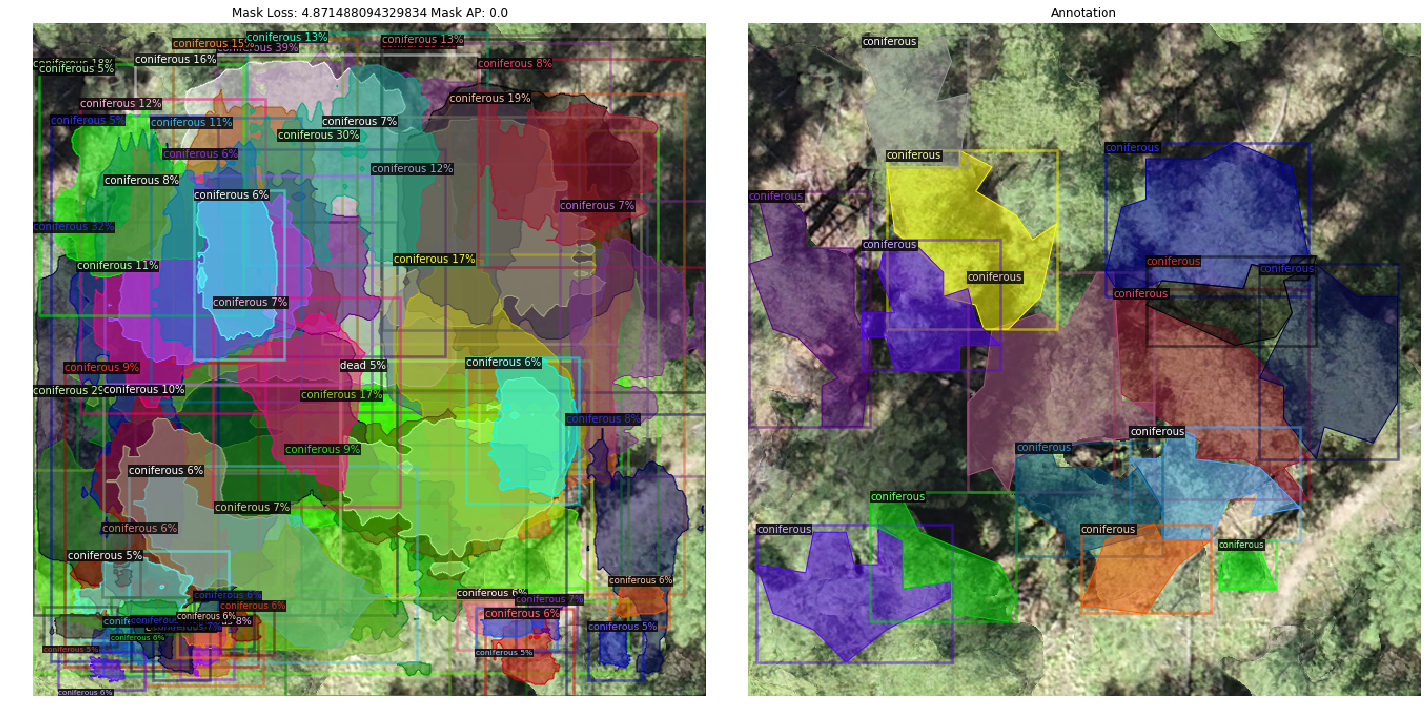

In [6]:
visualize([losses_and_metrics1],[predictor1],test_set_names,set_tile_paths)

In [7]:
 remove_temporary_dataset_dirs()

In [8]:
config = ind_eval_setup(arg_array1,test_set_names)

[04/07 20:28:50 detectron2]: Rank of current process: 0. World size: 1
[04/07 20:28:50 detectron2]: Environment info:
------------------------  --------------------------------------------------------------------------------------
sys.platform              linux
Python                    3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) [GCC 7.2.0]
numpy                     1.15.4
detectron2                0.1.1 @/home/ubuntu/drone-tree-id/lib/detectron2/detectron2
detectron2 compiler       GCC 5.4
detectron2 CUDA compiler  10.1
detectron2 arch flags     sm_75
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.4.0 @/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch
PyTorch debug build       False
CUDA available            True
GPU 0                     Tesla T4
CUDA_HOME                 /usr/local/cuda-10.1
NVCC                      Cuda compilation tools, release 10.1, V10.1.243
Pillow                    5.4.1
torchvision               0.5.0 @

[04/07 20:28:50 detectron2]: Running with full config:
CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ['temporary_0_test']
  TRAIN: ['temporary_0_test']
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: RGBA
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (600, 640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_deepent_fpn_backbone
  DEPTH_ENCODER:
    FREEZE_A

In [20]:
data_loader = DefaultTrainer.build_train_loader(config)
num_sets=2
_data_loader_iter = iter(data_loader)
losses = []
datas = []
model = Trainer.build_model(config)
# while len(losses.items()) < num_sets:
for i in range(20):
    assert model.training, "[SimpleTrainer] model was changed to eval mode!"
    start = time.perf_counter()
    data = next(_data_loader_iter)
    with EventStorage() as storage:
        loss_dict = model(data)
        print('\n')
        print(data)
        print(data[0]['file_name'])
        print(data[0]['image'])
        print(loss_dict['loss_mask'])

[04/07 21:09:50 d2.data.build]: Removed 0 images with no usable annotations. 1 images left.
[04/07 21:09:50 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[04/07 21:09:50 d2.data.common]: Serialized dataset takes 0.00 MiB
[04/07 21:09:50 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(600, 640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/07 21:09:50 d2.data.build]: Using training sampler TrainingSampler
[04/07 21:09:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[119, 115, 114,  ..., 141, 131, 127],
         [108, 110, 112,  ..., 137, 127, 123],
         [103,  99, 107,  ..., 133, 125, 119],
         ...,
         [151, 151, 143,  ...,  49,  42,  36],
         [147, 146, 146,  ...,  31,  24,  21],
         [140, 138, 145,  ...,  28,  26,  25]],

        [[184, 177, 175,  ..., 196, 186, 184],
         [173, 172, 173,  ..., 192, 184, 180],
         [162, 159, 167,  ..., 190, 184, 178],
         ...,
         [214, 216, 210,  ...,  69,  59,  51],
         [210, 212, 211,  ...,  47,  39,  36],
         [203, 200, 208,  ...,  45,  43,  40]],

        [[151, 148, 145,  ..., 174, 163, 159],
         [141, 144, 144,  ..., 170, 159, 155],
         [135, 130, 138,  ..., 165, 159, 153],
         ...,
         [187, 189, 183,  ...,  59,  51,  44],
         [184, 185, 183,  ...,  37,  29,  26],
         [176, 176, 18



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[119, 115, 114,  ..., 141, 131, 127],
         [113, 113, 112,  ..., 137, 129, 125],
         [103, 102, 107,  ..., 133, 125, 119],
         ...,
         [151, 151, 145,  ...,  46,  41,  34],
         [147, 145, 145,  ...,  29,  24,  23],
         [140, 137, 143,  ...,  28,  26,  25]],

        [[184, 178, 175,  ..., 194, 186, 184],
         [173, 173, 173,  ..., 192, 184, 182],
         [162, 162, 167,  ..., 190, 184, 178],
         ...,
         [214, 214, 210,  ...,  64,  55,  49],
         [210, 210, 209,  ...,  47,  41,  37],
         [203, 200, 208,  ...,  45,  43,  40]],

        [[151, 148, 145,  ..., 172, 163, 159],
         [146, 143, 144,  ..., 167, 161, 157],
         [135, 134, 140,  ..., 165, 159, 153],
         ...,
         [187, 187, 183,  ...,  55,  47,  41],
         [184, 184, 183,  ...,  37,  29,  27],
         [176, 175, 18



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[119, 115, 114,  ..., 141, 131, 127],
         [113, 113, 112,  ..., 137, 129, 125],
         [103, 102, 107,  ..., 133, 125, 119],
         ...,
         [151, 151, 145,  ...,  46,  41,  34],
         [147, 145, 145,  ...,  29,  24,  23],
         [140, 137, 143,  ...,  28,  26,  25]],

        [[184, 178, 175,  ..., 194, 186, 184],
         [173, 173, 173,  ..., 192, 184, 182],
         [162, 162, 167,  ..., 190, 184, 178],
         ...,
         [214, 214, 210,  ...,  64,  55,  49],
         [210, 210, 209,  ...,  47,  41,  37],
         [203, 200, 208,  ...,  45,  43,  40]],

        [[151, 148, 145,  ..., 172, 163, 159],
         [146, 143, 144,  ..., 167, 161, 157],
         [135, 134, 140,  ..., 165, 159, 153],
         ...,
         [187, 187, 183,  ...,  55,  47,  41],
         [184, 184, 183,  ...,  37,  29,  27],
         [176, 175, 18



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[127, 129, 139,  ..., 114, 115, 119],
         [125, 127, 137,  ..., 112, 113, 113],
         [121, 127, 133,  ..., 109, 103, 103],
         ...,
         [ 32,  37,  44,  ..., 147, 152, 151],
         [ 23,  24,  29,  ..., 145, 146, 147],
         [ 25,  26,  28,  ..., 143, 137, 140]],

        [[184, 186, 194,  ..., 175, 178, 184],
         [182, 184, 192,  ..., 173, 173, 173],
         [178, 184, 190,  ..., 169, 163, 162],
         ...,
         [ 47,  54,  62,  ..., 211, 216, 214],
         [ 38,  39,  46,  ..., 211, 210, 210],
         [ 40,  41,  45,  ..., 207, 201, 203]],

        [[159, 161, 172,  ..., 145, 149, 151],
         [157, 159, 167,  ..., 144, 144, 146],
         [153, 159, 165,  ..., 140, 134, 135],
         ...,
         [ 39,  44,  52,  ..., 184, 188, 187],
         [ 28,  29,  36,  ..., 185, 185, 184],
         [ 30,  31,  3



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[127, 131, 141,  ..., 114, 115, 119],
         [125, 129, 137,  ..., 112, 113, 113],
         [119, 125, 133,  ..., 107, 102, 103],
         ...,
         [ 34,  41,  46,  ..., 145, 151, 151],
         [ 23,  24,  29,  ..., 145, 145, 147],
         [ 25,  26,  28,  ..., 143, 137, 140]],

        [[184, 186, 194,  ..., 175, 178, 184],
         [182, 184, 192,  ..., 173, 173, 173],
         [178, 184, 190,  ..., 167, 162, 162],
         ...,
         [ 49,  55,  64,  ..., 210, 214, 214],
         [ 37,  41,  47,  ..., 209, 210, 210],
         [ 40,  43,  45,  ..., 208, 200, 203]],

        [[159, 163, 172,  ..., 145, 148, 151],
         [157, 161, 167,  ..., 144, 143, 146],
         [153, 159, 165,  ..., 140, 134, 135],
         ...,
         [ 41,  47,  55,  ..., 183, 187, 187],
         [ 27,  29,  37,  ..., 183, 184, 184],
         [ 30,  31,  3



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[119, 115, 114,  ..., 141, 131, 127],
         [113, 113, 112,  ..., 137, 129, 125],
         [103, 102, 107,  ..., 133, 125, 119],
         ...,
         [151, 151, 145,  ...,  46,  41,  34],
         [147, 145, 145,  ...,  29,  24,  23],
         [140, 137, 143,  ...,  28,  26,  25]],

        [[184, 178, 175,  ..., 194, 186, 184],
         [173, 173, 173,  ..., 192, 184, 182],
         [162, 162, 167,  ..., 190, 184, 178],
         ...,
         [214, 214, 210,  ...,  64,  55,  49],
         [210, 210, 209,  ...,  47,  41,  37],
         [203, 200, 208,  ...,  45,  43,  40]],

        [[151, 148, 145,  ..., 172, 163, 159],
         [146, 143, 144,  ..., 167, 161, 157],
         [135, 134, 140,  ..., 165, 159, 153],
         ...,
         [187, 187, 183,  ...,  55,  47,  41],
         [184, 184, 183,  ...,  37,  29,  27],
         [176, 175, 18



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[127, 131, 141,  ..., 114, 115, 119],
         [123, 127, 137,  ..., 112, 110, 108],
         [119, 125, 133,  ..., 107,  99, 103],
         ...,
         [ 36,  42,  49,  ..., 143, 151, 151],
         [ 21,  24,  31,  ..., 146, 146, 147],
         [ 25,  26,  28,  ..., 145, 138, 140]],

        [[184, 186, 196,  ..., 175, 177, 184],
         [180, 184, 192,  ..., 173, 172, 173],
         [178, 184, 190,  ..., 167, 159, 162],
         ...,
         [ 51,  59,  69,  ..., 210, 216, 214],
         [ 36,  39,  47,  ..., 211, 212, 210],
         [ 40,  43,  45,  ..., 208, 200, 203]],

        [[159, 163, 174,  ..., 145, 148, 151],
         [155, 159, 170,  ..., 144, 144, 141],
         [153, 159, 165,  ..., 138, 130, 135],
         ...,
         [ 44,  51,  59,  ..., 183, 189, 187],
         [ 26,  29,  37,  ..., 183, 185, 184],
         [ 30,  31,  3



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[127, 129, 139,  ..., 114, 115, 119],
         [125, 127, 137,  ..., 112, 113, 113],
         [121, 127, 133,  ..., 109, 103, 103],
         ...,
         [ 32,  37,  44,  ..., 147, 152, 151],
         [ 23,  24,  29,  ..., 145, 146, 147],
         [ 25,  26,  28,  ..., 143, 137, 140]],

        [[184, 186, 194,  ..., 175, 178, 184],
         [182, 184, 192,  ..., 173, 173, 173],
         [178, 184, 190,  ..., 169, 163, 162],
         ...,
         [ 47,  54,  62,  ..., 211, 216, 214],
         [ 38,  39,  46,  ..., 211, 210, 210],
         [ 40,  41,  45,  ..., 207, 201, 203]],

        [[159, 161, 172,  ..., 145, 149, 151],
         [157, 159, 167,  ..., 144, 144, 146],
         [153, 159, 165,  ..., 140, 134, 135],
         ...,
         [ 39,  44,  52,  ..., 184, 188, 187],
         [ 28,  29,  36,  ..., 185, 185, 184],
         [ 30,  31,  3



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[127, 131, 141,  ..., 114, 115, 119],
         [125, 129, 137,  ..., 112, 113, 113],
         [119, 125, 133,  ..., 107, 102, 103],
         ...,
         [ 34,  41,  46,  ..., 145, 151, 151],
         [ 23,  24,  29,  ..., 145, 145, 147],
         [ 25,  26,  28,  ..., 143, 137, 140]],

        [[184, 186, 194,  ..., 175, 178, 184],
         [182, 184, 192,  ..., 173, 173, 173],
         [178, 184, 190,  ..., 167, 162, 162],
         ...,
         [ 49,  55,  64,  ..., 210, 214, 214],
         [ 37,  41,  47,  ..., 209, 210, 210],
         [ 40,  43,  45,  ..., 208, 200, 203]],

        [[159, 163, 172,  ..., 145, 148, 151],
         [157, 161, 167,  ..., 144, 143, 146],
         [153, 159, 165,  ..., 140, 134, 135],
         ...,
         [ 41,  47,  55,  ..., 183, 187, 187],
         [ 27,  29,  37,  ..., 183, 184, 184],
         [ 30,  31,  3



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[121, 115, 114,  ..., 148, 131, 127],
         [107, 110, 113,  ..., 140, 129, 123],
         [ 99,  93, 110,  ..., 135, 127, 118],
         ...,
         [151, 150, 139,  ...,  62,  55,  44],
         [149, 149, 145,  ...,  35,  25,  21],
         [140, 137, 148,  ...,  30,  27,  25]],

        [[184, 177, 173,  ..., 201, 187, 184],
         [167, 171, 174,  ..., 195, 186, 180],
         [158, 154, 172,  ..., 192, 187, 177],
         ...,
         [216, 216, 204,  ...,  83,  73,  59],
         [213, 215, 211,  ...,  53,  41,  36],
         [203, 201, 213,  ...,  46,  43,  40]],

        [[154, 148, 144,  ..., 179, 163, 159],
         [140, 142, 146,  ..., 171, 162, 155],
         [131, 126, 143,  ..., 168, 161, 152],
         ...,
         [188, 188, 178,  ...,  72,  64,  53],
         [186, 188, 184,  ...,  43,  30,  26],
         [177, 175, 18



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[118, 114, 112,  ..., 149, 133, 127],
         [108, 109, 114,  ..., 139, 131, 123],
         [ 99,  95, 112,  ..., 135, 129, 117],
         ...,
         [150, 149, 136,  ...,  65,  60,  51],
         [148, 149, 141,  ...,  41,  31,  24],
         [140, 140, 146,  ...,  31,  26,  25]],

        [[184, 177, 171,  ..., 200, 188, 184],
         [170, 169, 173,  ..., 194, 188, 180],
         [155, 155, 173,  ..., 192, 186, 178],
         ...,
         [216, 213, 201,  ...,  87,  78,  65],
         [213, 215, 206,  ...,  60,  47,  39],
         [204, 203, 211,  ...,  50,  43,  40]],

        [[151, 147, 142,  ..., 178, 165, 159],
         [141, 140, 145,  ..., 170, 163, 155],
         [132, 128, 144,  ..., 167, 161, 153],
         ...,
         [188, 186, 175,  ...,  75,  70,  59],
         [186, 188, 181,  ...,  49,  36,  29],
         [178, 177, 18



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[119, 115, 114,  ..., 139, 129, 127],
         [113, 113, 112,  ..., 137, 127, 125],
         [103, 103, 109,  ..., 133, 127, 121],
         ...,
         [151, 152, 147,  ...,  44,  37,  32],
         [147, 146, 145,  ...,  29,  24,  23],
         [140, 137, 143,  ...,  28,  26,  25]],

        [[184, 178, 175,  ..., 194, 186, 184],
         [173, 173, 173,  ..., 192, 184, 182],
         [162, 163, 169,  ..., 190, 184, 178],
         ...,
         [214, 216, 211,  ...,  62,  54,  47],
         [210, 210, 211,  ...,  46,  39,  38],
         [203, 201, 207,  ...,  45,  41,  40]],

        [[151, 149, 145,  ..., 172, 161, 159],
         [146, 144, 144,  ..., 167, 159, 157],
         [135, 134, 140,  ..., 165, 159, 153],
         ...,
         [187, 188, 184,  ...,  52,  44,  39],
         [184, 185, 185,  ...,  36,  29,  28],
         [176, 176, 18



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[127, 133, 149,  ..., 112, 114, 118],
         [123, 131, 139,  ..., 114, 109, 108],
         [117, 129, 135,  ..., 112,  95,  99],
         ...,
         [ 51,  60,  65,  ..., 136, 149, 150],
         [ 24,  31,  41,  ..., 141, 149, 148],
         [ 25,  26,  31,  ..., 146, 140, 140]],

        [[184, 188, 200,  ..., 171, 177, 184],
         [180, 188, 194,  ..., 173, 169, 170],
         [178, 186, 192,  ..., 173, 155, 155],
         ...,
         [ 65,  78,  87,  ..., 201, 213, 216],
         [ 39,  47,  60,  ..., 206, 215, 213],
         [ 40,  43,  50,  ..., 211, 203, 204]],

        [[159, 165, 178,  ..., 142, 147, 151],
         [155, 163, 170,  ..., 145, 140, 141],
         [153, 161, 167,  ..., 144, 128, 132],
         ...,
         [ 59,  70,  75,  ..., 175, 186, 188],
         [ 29,  36,  49,  ..., 181, 188, 186],
         [ 30,  31,  4



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[127, 133, 149,  ..., 112, 114, 118],
         [123, 131, 139,  ..., 114, 109, 108],
         [117, 129, 135,  ..., 112,  95,  99],
         ...,
         [ 51,  60,  65,  ..., 136, 149, 150],
         [ 24,  31,  41,  ..., 141, 149, 148],
         [ 25,  26,  31,  ..., 146, 140, 140]],

        [[184, 188, 200,  ..., 171, 177, 184],
         [180, 188, 194,  ..., 173, 169, 170],
         [178, 186, 192,  ..., 173, 155, 155],
         ...,
         [ 65,  78,  87,  ..., 201, 213, 216],
         [ 39,  47,  60,  ..., 206, 215, 213],
         [ 40,  43,  50,  ..., 211, 203, 204]],

        [[159, 165, 178,  ..., 142, 147, 151],
         [155, 163, 170,  ..., 145, 140, 141],
         [153, 161, 167,  ..., 144, 128, 132],
         ...,
         [ 59,  70,  75,  ..., 175, 186, 188],
         [ 29,  36,  49,  ..., 181, 188, 186],
         [ 30,  31,  4



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[127, 131, 141,  ..., 114, 115, 119],
         [123, 127, 137,  ..., 112, 110, 108],
         [119, 125, 133,  ..., 107,  99, 103],
         ...,
         [ 36,  42,  49,  ..., 143, 151, 151],
         [ 21,  24,  31,  ..., 146, 146, 147],
         [ 25,  26,  28,  ..., 145, 138, 140]],

        [[184, 186, 196,  ..., 175, 177, 184],
         [180, 184, 192,  ..., 173, 172, 173],
         [178, 184, 190,  ..., 167, 159, 162],
         ...,
         [ 51,  59,  69,  ..., 210, 216, 214],
         [ 36,  39,  47,  ..., 211, 212, 210],
         [ 40,  43,  45,  ..., 208, 200, 203]],

        [[159, 163, 174,  ..., 145, 148, 151],
         [155, 159, 170,  ..., 144, 144, 141],
         [153, 159, 165,  ..., 138, 130, 135],
         ...,
         [ 44,  51,  59,  ..., 183, 189, 187],
         [ 26,  29,  37,  ..., 183, 185, 184],
         [ 30,  31,  3



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[119, 115, 114,  ..., 141, 131, 127],
         [108, 110, 112,  ..., 137, 127, 123],
         [103,  99, 107,  ..., 133, 125, 119],
         ...,
         [151, 151, 143,  ...,  49,  42,  36],
         [147, 146, 146,  ...,  31,  24,  21],
         [140, 138, 145,  ...,  28,  26,  25]],

        [[184, 177, 175,  ..., 196, 186, 184],
         [173, 172, 173,  ..., 192, 184, 180],
         [162, 159, 167,  ..., 190, 184, 178],
         ...,
         [214, 216, 210,  ...,  69,  59,  51],
         [210, 212, 211,  ...,  47,  39,  36],
         [203, 200, 208,  ...,  45,  43,  40]],

        [[151, 148, 145,  ..., 174, 163, 159],
         [141, 144, 144,  ..., 170, 159, 155],
         [135, 130, 138,  ..., 165, 159, 153],
         ...,
         [187, 189, 183,  ...,  59,  51,  44],
         [184, 185, 183,  ...,  37,  29,  26],
         [176, 176, 18



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[127, 131, 145,  ..., 114, 114, 119],
         [123, 129, 137,  ..., 112, 110, 108],
         [117, 127, 135,  ..., 109,  95,  97],
         ...,
         [ 41,  51,  57,  ..., 140, 151, 151],
         [ 21,  24,  32,  ..., 146, 149, 149],
         [ 25,  26,  30,  ..., 146, 137, 140]],

        [[184, 186, 198,  ..., 173, 177, 184],
         [180, 186, 194,  ..., 173, 171, 168],
         [176, 186, 192,  ..., 169, 155, 157],
         ...,
         [ 55,  67,  77,  ..., 206, 217, 216],
         [ 36,  41,  51,  ..., 210, 213, 212],
         [ 40,  43,  46,  ..., 211, 201, 203]],

        [[159, 163, 176,  ..., 144, 148, 151],
         [155, 161, 170,  ..., 145, 142, 141],
         [151, 161, 167,  ..., 140, 128, 130],
         ...,
         [ 49,  59,  67,  ..., 179, 189, 187],
         [ 26,  29,  41,  ..., 183, 186, 185],
         [ 30,  31,  3



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[127, 131, 141,  ..., 114, 115, 119],
         [125, 129, 137,  ..., 112, 113, 113],
         [119, 125, 133,  ..., 107, 102, 103],
         ...,
         [ 34,  41,  46,  ..., 145, 151, 151],
         [ 23,  24,  29,  ..., 145, 145, 147],
         [ 25,  26,  28,  ..., 143, 137, 140]],

        [[184, 186, 194,  ..., 175, 178, 184],
         [182, 184, 192,  ..., 173, 173, 173],
         [178, 184, 190,  ..., 167, 162, 162],
         ...,
         [ 49,  55,  64,  ..., 210, 214, 214],
         [ 37,  41,  47,  ..., 209, 210, 210],
         [ 40,  43,  45,  ..., 208, 200, 203]],

        [[159, 163, 172,  ..., 145, 148, 151],
         [157, 161, 167,  ..., 144, 143, 146],
         [153, 159, 165,  ..., 140, 134, 135],
         ...,
         [ 41,  47,  55,  ..., 183, 187, 187],
         [ 27,  29,  37,  ..., 183, 184, 184],
         [ 30,  31,  3



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[127, 131, 143,  ..., 114, 114, 119],
         [123, 129, 137,  ..., 112, 110, 108],
         [119, 125, 133,  ..., 109,  97,  97],
         ...,
         [ 39,  46,  54,  ..., 141, 150, 151],
         [ 21,  24,  32,  ..., 145, 146, 147],
         [ 25,  26,  30,  ..., 145, 137, 140]],

        [[184, 186, 196,  ..., 173, 176, 184],
         [180, 186, 192,  ..., 173, 170, 168],
         [176, 184, 190,  ..., 169, 157, 157],
         ...,
         [ 54,  64,  74,  ..., 208, 215, 216],
         [ 36,  41,  49,  ..., 212, 213, 210],
         [ 40,  43,  46,  ..., 210, 201, 203]],

        [[159, 163, 174,  ..., 144, 146, 151],
         [155, 161, 167,  ..., 145, 142, 141],
         [151, 159, 165,  ..., 140, 129, 130],
         ...,
         [ 46,  54,  64,  ..., 181, 188, 187],
         [ 26,  29,  39,  ..., 185, 187, 184],
         [ 30,  31,  3



[{'file_name': '/home/ubuntu/RGBD-Training-Data/test/Kelowna/tile_30.png', 'image_id': 1395, 'width': 640, 'height': 640, 'image': tensor([[[127, 131, 148,  ..., 114, 115, 121],
         [123, 129, 140,  ..., 113, 110, 107],
         [118, 127, 135,  ..., 110,  93,  99],
         ...,
         [ 44,  55,  62,  ..., 139, 150, 151],
         [ 21,  25,  35,  ..., 145, 149, 149],
         [ 25,  27,  30,  ..., 148, 137, 140]],

        [[184, 187, 201,  ..., 173, 177, 184],
         [180, 186, 195,  ..., 174, 171, 167],
         [177, 187, 192,  ..., 172, 154, 158],
         ...,
         [ 59,  73,  83,  ..., 204, 216, 216],
         [ 36,  41,  53,  ..., 211, 215, 213],
         [ 40,  43,  46,  ..., 213, 201, 203]],

        [[159, 163, 179,  ..., 144, 148, 154],
         [155, 162, 171,  ..., 146, 142, 140],
         [152, 161, 168,  ..., 143, 126, 131],
         ...,
         [ 53,  64,  72,  ..., 178, 188, 188],
         [ 26,  30,  43,  ..., 184, 188, 186],
         [ 30,  32,  3

In [18]:
data_loader